In [139]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')


In [140]:
# 2.Load Dataset
data = pd.read_csv("hanoi_quality.csv")
data

,date,pm25,pm10,o3,no2,so2,co
0,3/1/2019,76,1,15,36,7,7
1,3/2/2019,117,64,4,28,3,5
2,3/3/2019,10,64,1,22,16,5
3,3/4/2019,118,56,13,22,14,6
4,3/5/2019,2,34,15,21,6,6
...,...,...,...,...,...,...,...
1915,5/28/2024,85,56,14,1,8,6
1916,5/29/2024,58,50,13,1,8,6
1917,5/30/2024,47,39,10,1,8,8
1918,5/31/2024,48,63,10,1,8,8


In [141]:
#kích thước dữ liệu
data.shape
data.info()
#Mô tả bộ dữ liệu
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1920 entries, 0 to 1919
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    1920 non-null   object
 1   pm25    1920 non-null   int64 
 2   pm10    1920 non-null   int64 
 3   o3      1920 non-null   int64 
 4   no2     1920 non-null   int64 
 5   so2     1920 non-null   int64 
 6   co      1920 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 105.1+ KB


,pm25,pm10,o3,no2,so2,co
count,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000
mean,63.091667,39.147917,16.548958,19.444271,11.690104,7.580208
std,40.260213,21.942295,16.580522,10.014321,6.428450,2.986652
min,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,32.000000,22.000000,8.000000,13.000000,7.000000,5.000000
50%,54.500000,36.000000,14.000000,19.000000,11.000000,7.000000
75%,88.000000,54.000000,21.000000,27.000000,17.000000,9.000000
max,217.000000,121.000000,441.000000,53.000000,43.000000,21.000000


In [142]:
#Chọn thuộc tính
data = data[['pm25']]
data = data.dropna()
data = data.reset_index(drop=True)
data

,pm25
0,76
1,117
2,10
3,118
4,2
...,...
1915,85
1916,58
1917,47
1918,48


In [143]:
def smoothed(data):
    # Apply moving average filter to smooth the forecasted values
    window_size = 5  # You can adjust the window size as needed
    forecast_smoothed = data.rolling(window=window_size).mean()

    # Interpolate NaN values resulting from the moving average
    forecast_smoothed_interpolated = forecast_smoothed.interpolate()

    # Fill remaining NaN values
    forecast_smoothed_filled = forecast_smoothed_interpolated.fillna(method='bfill')  # or 'ffill', or use fillna(value=0)

    return forecast_smoothed_filled

# Example usage
data = smoothed(data)


In [144]:
data

,pm25
0,64.6
1,64.6
2,64.6
3,64.6
4,64.6
...,...
1915,62.4
1916,54.2
1917,55.8
1918,59.4


<Axes: >

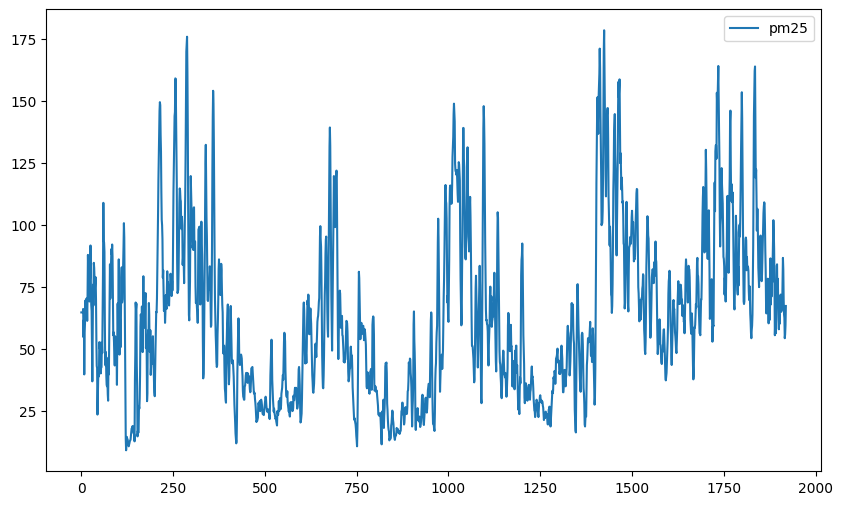

In [145]:
data.plot(figsize=(10,6))

In [146]:
# 2. Đọc file dữ liệu và chia train test theo tỉ lệ 7:3
train_size = int(0.7 * len(data))
test_size = int(0.3 * len(data))

# Chia dữ liệu thành các tập
train_data = data[:train_size]
test_data = data[train_size:]

# Kiểm tra kích thước của từng tập
print("Train data size:", len(train_data))
print("Test data size:", len(test_data))


Train data size: 1344
Test data size: 576


In [147]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['pm25'])

from pmdarima.arima import auto_arima
model = auto_arima(y_train, start_p=1, start_q=1,
                   test='adf',       # use adf test to find optimal 'd'
                   max_p=4, max_q=4, # maximum p and q
                   m=1,              # frequency of series
                   d=None,           # let model determine 'd'
                   seasonal=False,   # No Seasonality
                   start_P=0,
                   D=0,
                   trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=9154.330, Time=0.49 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=14932.510, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=13240.640, Time=0.75 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=9100.088, Time=0.61 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=9102.132, Time=0.42 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=9101.667, Time=1.57 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=9101.923, Time=1.22 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=9111.317, Time=0.43 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=9100.241, Time=0.19 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=2.11 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=9047.395, Time=0.59 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=9124.853, Time=0.53 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=9045.665, Time=0.44 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC

ARIMA(order=(2, 0, 0), scoring_args={}, suppress_warnings=True)

In [148]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data)
y_pred = model.predict(n_periods=len(y_test))


In [149]:
y_pred = pd.DataFrame(y_pred, columns=['pm25'])
y_pred = smoothed(y_pred)
y_pred = y_pred.to_numpy()

In [150]:
last_index

1919

In [151]:
# 4. Quá trình tạo index predict 90 ngày tiếp theo
last_index =  data.index[-1]
last_data = pd.RangeIndex(start=last_index + 1, stop=last_index+91, step=1)

# Tạo mảng 90 ngày
x_next_90_days = np.array(range(last_index+1, last_index+91)).reshape(-1, 1)

# Dự đoán 90 ngày tiếp theo
y_next_90_days = model.predict(n_periods=len(x_next_90_days))

# # In ra dự đoán giá trong 90 ngày tiếp theo
print('Predicted closing prices for the next 90 days:')
print(y_next_90_days)

Predicted closing prices for the next 90 days:
[30.74896088 28.58874176 28.87809635 30.42316177 32.5353833  34.82624882
 37.08429129 39.20153748 41.12965537 42.85392154 44.37786573 45.71429938
 46.88014989 47.8935535  48.77227996 49.53293483 50.19060928 50.75878119
 51.24935234 51.67275403 52.03808255 52.35324258 52.62508708 52.85954741
 53.06175147 53.23612903 53.38650468 53.51617926 53.62800079 53.72442617
 53.80757457 53.87927377 53.94110003 53.99441272 54.04038409 54.08002502
 54.11420719 54.14368229 54.1690985  54.19101475 54.20991299 54.22620882
 54.24026061 54.25237738 54.26282559 54.27183502 54.27960378 54.28630274
 54.2920792  54.29706021 54.3013553  54.30505893 54.30825254 54.31100637
 54.31338098 54.3154286  54.31719424 54.31871674 54.32002958 54.32116164
 54.3221378  54.32297954 54.32370536 54.32433124 54.32487093 54.3253363
 54.32573758 54.32608361 54.32638198 54.32663927 54.32686113 54.32705243
 54.32721739 54.32735964 54.3274823  54.32758806 54.32767927 54.32775791
 54.3

In [152]:
# 5. Tính RMSE
test_rmse = np.sqrt(np.mean((y_test - y_pred)**2))
print('Testing RMSE:', test_rmse)

# 6. Tính MAPE
test_mape = np.mean(np.abs((y_test - y_pred)/y_test))*100
print('\nTesting MAPE:', test_mape)

# 7. Tính MAE
test_mae = np.mean(np.abs(y_test - y_pred))
print("\nMAE:", test_mae)

Testing RMSE: 41.83914583767339

Testing MAPE: 34.23318502424989

MAE: 32.03248254792277


In [153]:
test_data.index

RangeIndex(start=1344, stop=1920, step=1)

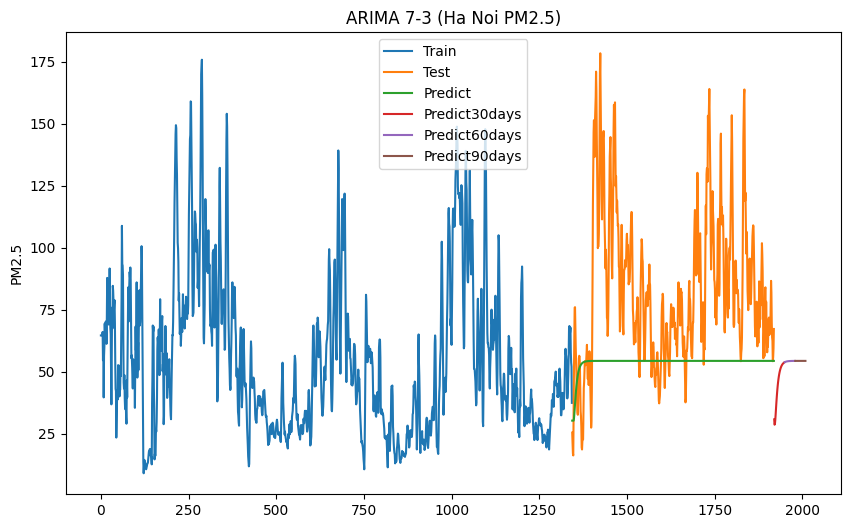

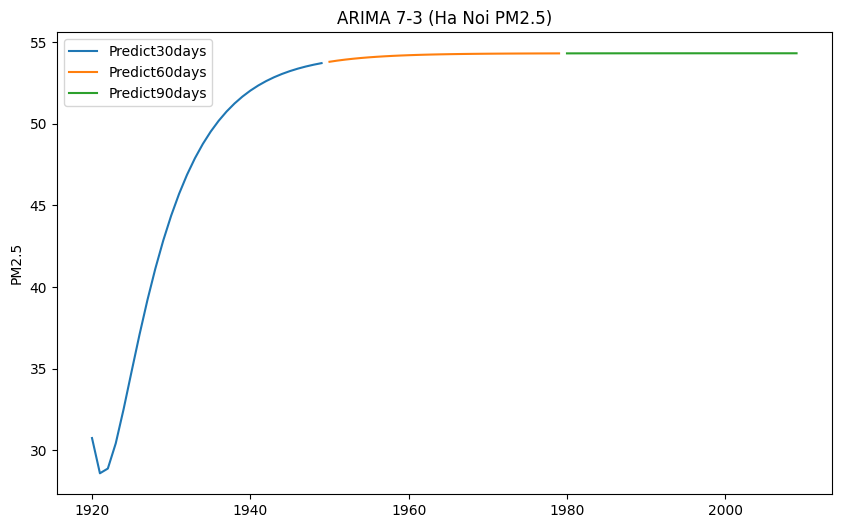

In [154]:
# 9.Vẽ hình
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(test_data.index, y_pred)


last_data = pd.RangeIndex(start=last_index+1, stop=last_index+31, step=1)
plt.plot(last_data,y_next_90_days[0:30])

last_data = pd.RangeIndex(start=last_index+31, stop=last_index+61, step=1)
plt.plot(last_data,y_next_90_days[30:60])

last_data = pd.RangeIndex(start=last_index+61, stop=last_index+91, step=1)
plt.plot(last_data,y_next_90_days[60:90])
plt.legend(['Train','Test','Predict','Predict30days', 'Predict60days', 'Predict90days'])
plt.title('ARIMA 7-3 (Ha Noi PM2.5)')
plt.ylabel('PM2.5')
plt.show()


#DỰ đians 90 ngày
plt.figure(figsize=(10, 6))
last_data = pd.RangeIndex(start=last_index+1, stop=last_index+31, step=1)
plt.plot(last_data,y_next_90_days[0:30])

last_data = pd.RangeIndex(start=last_index+31, stop=last_index+61, step=1)
plt.plot(last_data,y_next_90_days[30:60])

last_data = pd.RangeIndex(start=last_index+61, stop=last_index+91, step=1)
plt.plot(last_data,y_next_90_days[60:90])
plt.legend(['Predict30days', 'Predict60days', 'Predict90days'])
plt.title('ARIMA 7-3 (Ha Noi PM2.5)')
plt.ylabel('PM2.5')
plt.show()

